In [1]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from stravalib.client import Client
import ast
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

from src.get_strava_data import StravaAthlete
import src.data_cleanup as cln

import polyline

pd.set_option('display.max_columns', 500)

In [2]:
# ath_df = pd.read_csv('data/athletes.csv') 
# ride_ids = pd.read_csv('data/Feldy_Bikes/ride_ids.csv')
# segments_df = pd.read_csv('data/Feldy_Bikes/segments_df.csv')
# efforts_df = pd.read_csv('data/Feldy_Bikes/efforts_df.csv')
seg_details_df = pd.read_csv('data/seg_details_df.csv')

In [3]:
map_dict = ast.literal_eval(seg_details_df.map[0])
map_dict

{'id': 's12338997',
 'polyline': 'kjtqFhweaSBC?Qn@sA\\RSn@',
 'summary_polyline': None}

In [4]:

# vals = seg_details_df['map'].apply(ast.literal_eval)
# lst = []
# for row in vals:
#     lst.append(row['polyline'])
# arr = np.array(lst)
# seg_details_df['polyline'] = arr

In [5]:
def unpack_dict_col(df, col, key):
    vals = df[col].apply(ast.literal_eval)
    lst = []
    for row in vals:
        lst.append(row[key])
    arr = np.array(lst)
    df[key] = arr
    return df

In [6]:
seg_details_df = unpack_dict_col(seg_details_df, 'map', 'polyline')

In [7]:
seg_details_df.head(3)

,segment_id,name,distance,average_grade,maximum_grade,elevation_high,elevation_low,total_elevation_gain,start_latitude,end_latitude,start_longitude,end_longitude,climb_category,city,state,country,effort_count,athlete_count,athlete_segment_stats,map,polyline
0,12338997,For All The Lil Groms,94.30,-2.3,1.5,1677.4,1674.4,0.0000,39.758621,39.758319,-105.219889,-105.219699,0,Golden,Colorado,United States,22291,5310,"{'effort_count': 104, 'pr_elapsed_time': '0:00...","{'id': 's12338997', 'polyline': 'kjtqFhweaSBC?...",kjtqFhweaSBC?Qn@sA\RSn@
1,991763,Tunnel to Tunnel,445.34,4.5,29.1,1809.3,1788.7,23.5522,39.735290,39.731473,-105.214684,-105.215807,0,Golden,CO,United States,14963,2849,"{'effort_count': 221, 'pr_elapsed_time': '0:00...","{'id': 's991763', 'polyline': 'qxoqFxvdaSrATLr...",qxoqFxvdaSrATLrATh@b@Jd@Vh@b@h@Rv@P~@\l@^v@Vh@...
2,1284311,Golden Cruise: Parking Lot to First Parking Ga...,485.70,-0.5,6.1,1726.4,1722.2,0.0000,39.759567,39.756275,-105.219683,-105.220585,0,Golden,CO,United States,1780,642,"{'effort_count': 129, 'pr_elapsed_time': '0:01...","{'id': 's1284311', 'polyline': 'gptqF`veaSVl@V...",gptqF`veaSVl@Vb@VANS@Qx@c@J@R\ZDh@c@PGJ?@FZD\?...


In [8]:
polyline.decode('kjtqFhweaSBC?Qn@sA\\RSn@', geojson=True)

[(-105.21989, 39.75862),
 (-105.21987, 39.7586),
 (-105.21978, 39.7586),
 (-105.21936, 39.75836),
 (-105.21946, 39.75821),
 (-105.2197, 39.75831)]

In [9]:

seg_details_df.index[seg_details_df.segment_id == 12338997][0]

0

In [10]:
def curvy1(pline):
    waypoints = polyline.decode(pline)
    cos_dist = []
    dist = []
    for i in range(len(waypoints)-2):
        vectA = np.array(waypoints[i+1])-np.array(waypoints[i])
        vectB = np.array(waypoints[i+2])-np.array(waypoints[i+1])
        cos_dist.append(cosine_distances(np.array([vectA,vectB]))[0,1])
        
        distA = np.sqrt((waypoints[i][0]-waypoints[i+1][0])**2+(waypoints[i][1]-waypoints[i+1][1])**2)
        distB = np.sqrt((waypoints[i+1][0]-waypoints[i+2][0])**2+(waypoints[i+1][1]-waypoints[i+2][1])**2)
        dist.append(distA + distB)
    curve = []
    for i in range(len(dist)):
        curve.append(cos_dist[i]/dist[i])
    return np.mean(curve)

def curvy2(pline):
    waypoints = polyline.decode(pline)
    curve = []
    wp = []
    for i in range(len(waypoints)-2):
        wp.append([waypoints[i+2]])
        vectA = np.array(waypoints[i+1])-np.array(waypoints[i])
        vectB = np.array(waypoints[i+2])-np.array(waypoints[i])
        vectC = np.array(waypoints[i+2])-np.array(waypoints[i])
        
        distA = np.sqrt((waypoints[i][0]-waypoints[i+1][0])**2+(waypoints[i][1]-waypoints[i+1][1])**2)
        distB = np.sqrt((waypoints[i+1][0]-waypoints[i+2][0])**2+(waypoints[i+1][1]-waypoints[i+2][1])**2)
        distC = np.sqrt((waypoints[i][0]-waypoints[i+2][0])**2+(waypoints[i][1]-waypoints[i+2][1])**2)
        curve.append((distA + distB - distC)/(distA + distB))
    return np.mean(curve)

In [11]:
def plot_segment_map(df, seg, ax):
    row = df.index[df.segment_id == seg][0]
    xy = polyline.decode(df.polyline[row])
    
    name = df.name[row]
    curve1 = curvy1(df.polyline[row])
    curve2 = curvy2(df.polyline[row])
    
    x = []
    y = []
    for i in xy:
        x.append(i[1])
        y.append(i[0])
    
    xrange = max(x)-min(x)
    yrange = max(y)-min(y)
    if xrange > yrange:
        range = xrange
    else:
        range = yrange
    
    #fig, ax = plt.subplots(figsize = (6,6)) 
    
    ax.plot(x, y, linestyle='-', marker='o', ms = 3)
    ax.plot(x[0], y[0], marker='o', c = 'green', ms = 15, label = 'start')
    ax.plot(x[-1], y[-1], marker='o', color = 'red', ms = 15, label = 'end')
    ax.set_xlim(min(x) - range*0.1, min(x) + range*1.1)
    ax.set_ylim(min(y) - range*0.1, min(y) + range*1.1)
    ax.tick_params(axis='x', rotation=90)
    ax.annotate('start', xy=(x[0],y[0]))#, xytext=(.00000000000003, .00000000000003),arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('end', xy=(x[-1],y[-1]))
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_title('{0} \n curvy1: {1} \n curvy2: {2}'.format(name, curve1, curve2))
    return ax

def plot_polyline(pline):
    curve1 = curvy1(pline)
    curve2 = curvy2(pline)
    
    xy = polyline.decode(pline)
    x = []
    y = []
    for i in xy:
        x.append(i[1])
        y.append(i[0])
    
    xrange = max(x)-min(x)
    yrange = max(y)-min(y)
    if xrange > yrange:
        range = xrange
    else:
        range = yrange
    
    fig, ax = plt.subplots(figsize = (6,6))    
    
    ax.plot(x, y, linestyle='-', marker='o', ms = 1)
    ax.plot(x[0], y[0], marker='o', c = 'green', ms = 15, label = 'start')
    ax.plot(x[-1], y[-1], marker='o', color = 'red', ms = 15, label = 'end')
    ax.set_xlim(min(x) - range*0.1, min(x) + range*1.1)
    ax.set_ylim(min(y) - range*0.1, min(y) + range*1.1)
    ax.tick_params(axis='x', rotation=90)
    ax.annotate('start', xy=(x[0],y[0]))
    ax.annotate('end', xy=(x[-1],y[-1]))
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_title('curvy1: {0} \n curvy2: {1}'.format(curve1,curve2))

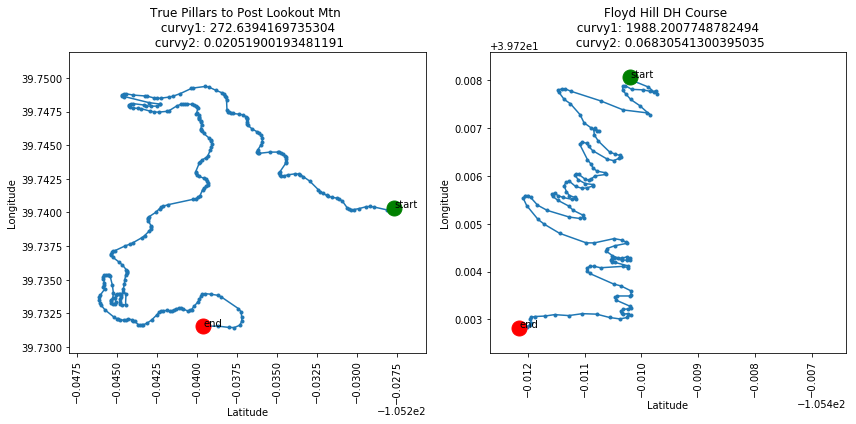

In [12]:
fig, axs = plt.subplots(1,2, figsize = (12,6))


segment_list = [2764729, 21464534]

for ax, segment in zip(axs.flatten(),segment_list):
    plot_segment_map(seg_details_df, segment, ax)

plt.tight_layout()


In [13]:
#seg_details_df[['segment_id','name','poly_line']]

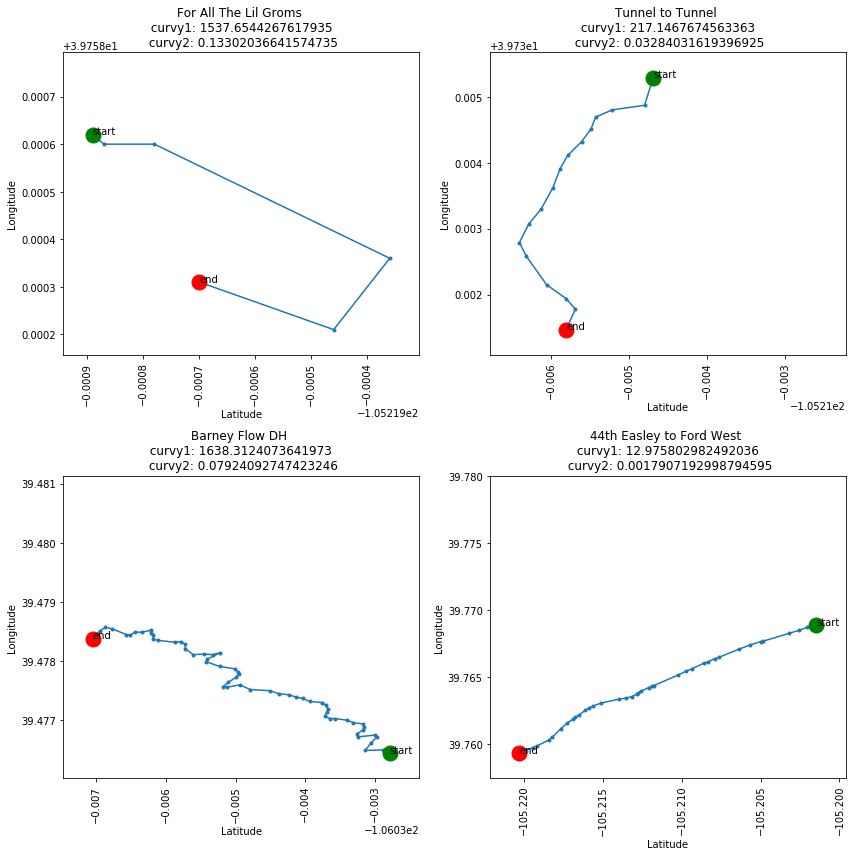

In [14]:
fig, axs = plt.subplots(2,2, figsize = (12,12))


segment_list = [12338997,991763,12677053,17747809]

for ax, segment in zip(axs.flatten(),segment_list):
    plot_segment_map(seg_details_df, segment, ax)

plt.tight_layout()

In [15]:
def plot_polyline(pline):
    curve1 = curvy1(pline)
    curve2 = curvy2(pline)
    
    xy = polyline.decode(pline)
    x = []
    y = []
    for i in xy:
        x.append(i[0])
        y.append(i[1])
    
    xrange = max(x)-min(x)
    yrange = max(y)-min(y)
    if xrange > yrange:
        range = xrange
    else:
        range = yrange
    
    fig, ax = plt.subplots(figsize = (6,6))    
    
    ax.plot(x, y, linestyle='-', marker='o')
    ax.plot(x[0], y[0], marker='o', c = 'green', ms = 15, label = 'start')
    ax.plot(x[-1], y[-1], marker='o', color = 'red', ms = 15, label = 'end')
    ax.set_xlim(min(x) - range*0.1, min(x) + range*1.1)
    ax.set_ylim(min(y) - range*0.1, min(y) + range*1.1)
    ax.tick_params(axis='x', rotation=90)
    ax.annotate('start', xy=(x[0],y[0]))
    ax.annotate('end', xy=(x[-1],y[-1]))
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_title('curvy1: {0} \n curvy2: {1}'.format(curve1,curve2))

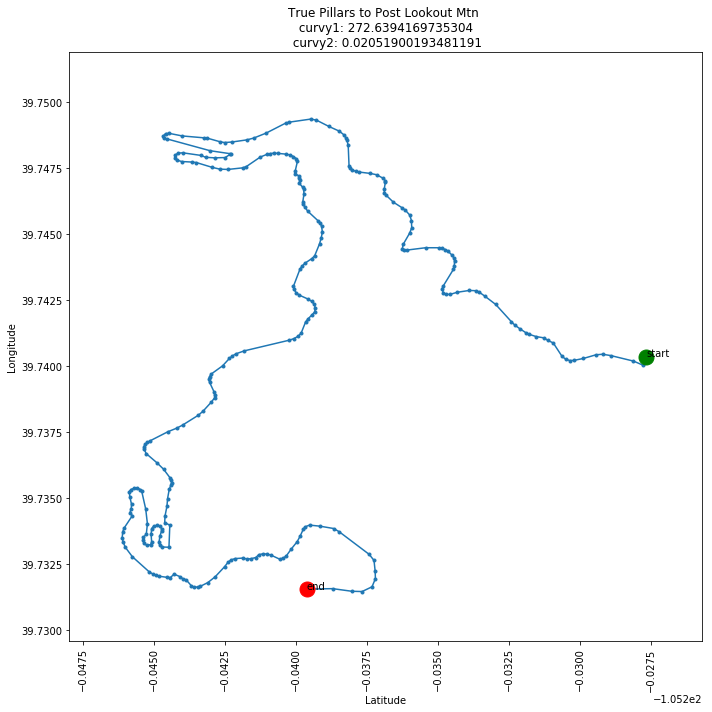

In [16]:
fig, ax = plt.subplots(1,1, figsize = (10,10))


segment_list = [2764729]

plot_segment_map(seg_details_df, 2764729, ax)

plt.tight_layout()

In [17]:
seg_details_df.index[seg_details_df.segment_id == 1250828]

Int64Index([], dtype='int64')

In [18]:
row = seg_details_df.index[seg_details_df.segment_id == 1250828][0]
seg_details_df.polyline[row]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
plot_polyline('qjvqFbdbaSFd@XpAj@dBl@zBtBlIBVr@jCz@fC|BdGPp@j@lAVx@pAvCb@dA|@nBxCjHDRVl@v@dBV^PNd@`AThANtAv@~En@nB\\n@^l@`AfAd@t@VV~@nAtApA|BhBf@h@vAvCXv@l@vA^lA')

In [ ]:
seg_details_df.poly_line[0]

In [ ]:
np.array(polyline.decode(seg_details_df.poly_line[5])).shape

In [ ]:
curvy2(seg_details_df.poly_line[5])

In [ ]:
np.array(polyline.decode(seg_details_df.poly_line[0])).shape

In [ ]:
curvy2(seg_details_df.poly_line[0])

In [ ]:
pline